# Examples of plotting TrackRun subsets

Import the necessary modules

**Note** Examples below require `cartopy` package to be installed

In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

from octant.core import TrackRun, OctantTrack

To save time, in this example `lcc_map` function is used to create a map in Lambert Conformal Conic projection.

In [2]:
def lcc_map(fig, subplot_grd=111, clon=None, clat=None, coast=None, extent=None):
    """Create cartopy axes in Lambert Conformal projection."""
    proj = ccrs.LambertConformal(central_longitude=clon, central_latitude=clat)

    # Draw a set of axes with coastlines:
    ax = fig.add_subplot(subplot_grd, projection=proj)
    if isinstance(extent, list):
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    if isinstance(coast, dict):
        feature = cartopy.feature.NaturalEarthFeature(
            name="coastline", category="physical", **coast
        )
        ax.add_feature(feature)
    return ax

Some useful declarations for plotting...

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)  # change the default figure size
COAST = dict(scale="50m", alpha=0.5, edgecolor="#333333", facecolor="#AAAAAA")
clon = 10
clat = 75
extent = [-20, 50, 65, 85]
LCC_KW = dict(clon=clon, clat=clat, coast=COAST, extent=extent)

mapkw = dict(transform=ccrs.PlateCarree())

Define the common data directory

In [4]:
sample_dir = Path(".") / "sample_data"

Data are usually organised in hierarchical directory structure. Here, the relevant parameters are defined.

In [5]:
dataset = "era5"
period = "test"
run_id = 0

Construct the full path

In [6]:
track_res_dir = sample_dir / dataset / f"run{run_id:03d}" / period

## Load the data

Load land-sea mask array from ERA5 dataset:

In [7]:
lsm = xr.open_dataarray(sample_dir / dataset / "lsm.nc")
lsm = lsm.squeeze()  # remove singular time dimension

Now load the cyclone tracks themselves

In [8]:
tr = TrackRun(track_res_dir)

In [9]:
tr

<octant.core.TrackRun> [671 tracks]

In [10]:
conditions = [
    ("long_lived", [lambda ot: ot.lifetime_h >= 6]),
    (
        "far_travelled_and_very_long_lived",
        [lambda ot: ot.lifetime_h >= 36, lambda ot: ot.gen_lys_dist_km > 300.0],
    ),
    ("strong", [lambda x: x.max_vort > 1e-3]),
]

In [11]:
tr.classify(conditions)

... and classify them

What are the indices of "strong" cyclones?

In [12]:
tr["strong"].index.get_level_values("track_idx").unique()

Int64Index([93, 182, 252, 569, 631], dtype='int64', name='track_idx')

## Simple track plot

Select an `OctantTrack` by its absolute index

In [13]:
import pandas as pd

In [14]:
random_track = tr["strong"].loc[182]

Here the variable `random_track` is a subclass of `pandas.DataFrame`, and it has the following additional attributes and methods:

In [15]:
set(random_track.__dir__()).difference(set(pd.DataFrame().__dir__()))

{'area',
 'average_speed',
 'coord_view',
 'from_df',
 'from_mux_df',
 'gb',
 'gen_lys_dist_km',
 'lat',
 'lifetime_h',
 'lon',
 'lonlat',
 'lonlat_c',
 'max_vort',
 'plot_track',
 'time',
 'total_dist_km',
 'tridlonlat',
 'tridlonlat_c',
 'vo',
 'vortex_type',
 'within_rectangle'}

One of them is `plot_track()` method, which is a small wrapper around `matplotlib.pyplot.plot()` function.

The important (optional) parameter is `ax=`, via which a track can be plotted in the given axes. For example, below a figure `fig` is created along with `ax`, geo-referenced axes, and then the chosen track is added to the plot. The remaining parameters that can be passed to `plot_track` are keyword arguments of `matplotlib.pyplot.plot(*args, **kwargs)` function.

#### Plot a single track on a map

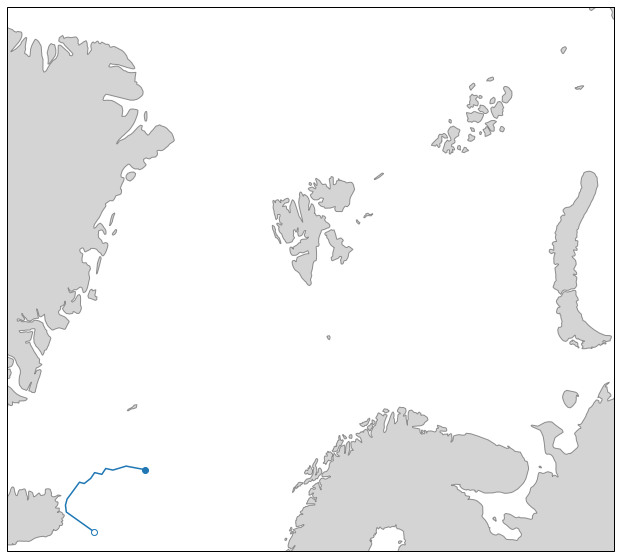

In [16]:
fig = plt.figure()
ax = lcc_map(fig, **LCC_KW)
random_track.plot_track(ax=ax, color=None);

#### Plot a single track without a map

##### a) In the given Axes

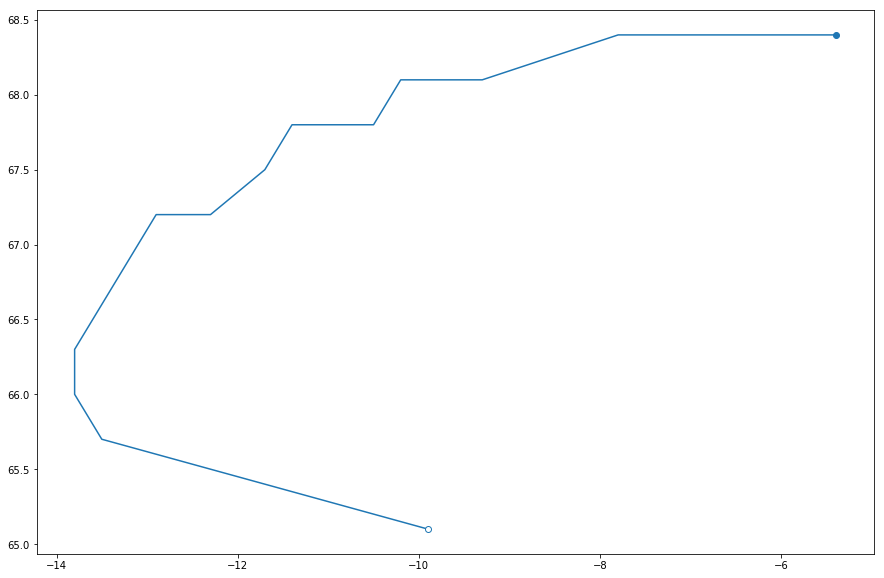

In [17]:
fig, ax = plt.subplots()
random_track.plot_track(ax=ax);

##### b) Or automatically create figure and axes in the `PlateCarree` projection

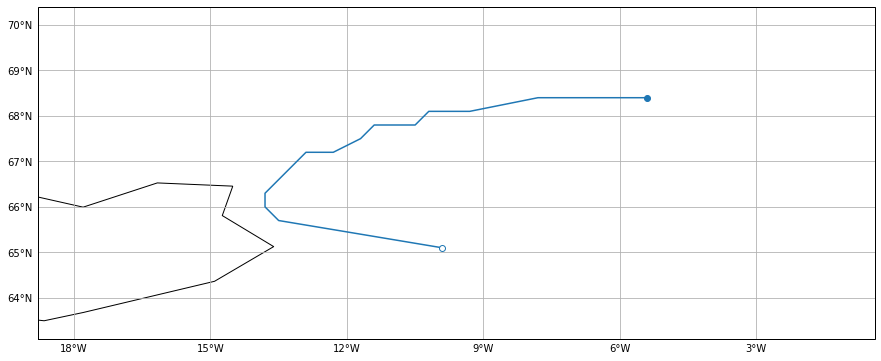

In [18]:
random_track.plot_track();

The function returns matplotlib axes object, so it can be used for further plotting.

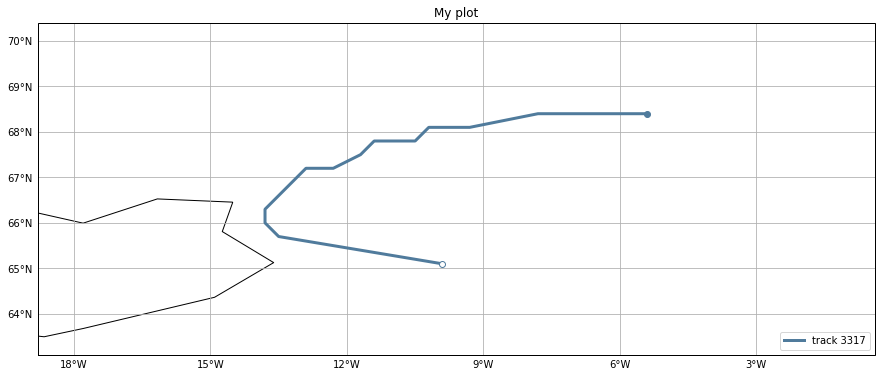

In [19]:
ax1 = random_track.plot_track(color='xkcd:stormy blue',
                              linewidth=3,
                              label=f'track 3317')
ax1.legend(loc=4)
ax1.set_title('My plot');

## Plot all tracks from TrackRun

In [20]:
subsets_and_colors = [("long_lived", "#424242"), ("far_travelled_and_very_long_lived", "C0"), ("strong", "C1")]

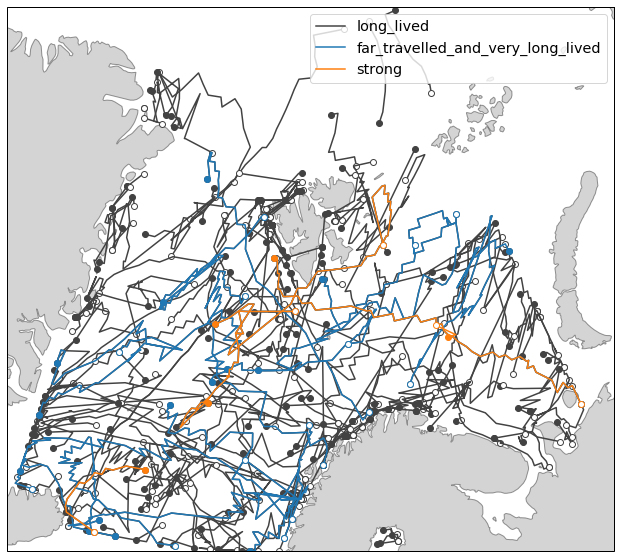

In [21]:
fig = plt.figure()
ax = lcc_map(fig, **LCC_KW)

handles, labels = [], []
for subset_label, color in subsets_and_colors:
    for (_, track) in tr[subset_label].gb:
        track.plot_track(ax=ax, color=color, label=subset_label)

labels, handles = [
    list(getattr({j: i for i, j in zip(*ax.get_legend_handles_labels())}, m)())
    for m in ["keys", "values"]
]
ax.legend(handles, labels, fontsize="x-large", loc=1);